## Inspect Attention and MLP Weights

This notebook loads the legacy ViT model (`models.vision_transformer.ViT`), finds all Attention and MLP submodules, and plots histograms of their parameter weights. It supports optionally loading a checkpoint.

- Update the paths in the Config cell below.
- Run the cells to visualize per-layer and aggregated weight distributions.


In [1]:
# Imports and setup
import os
import sys
import toml
from typing import Dict, List, Tuple, Optional

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Ensure src is on path
repo_root = "/glade/u/home/jshen/pruning-turbulence-vit"
src_dir = os.path.join(repo_root, "src")
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

from models.vision_transformer import ViT as LegacyViT

# Identify attention/MLP classes for legacy implementation only
from models.legacy_modules.attention import Attention as LegacyAttention
from models.legacy_modules.mlp import MLP as LegacyMLP


In [2]:
# Config
CONFIG_TOML = "/glade/u/home/jshen/pruning-turbulence-vit/src/config/train/base_vit.toml"  # or another config
CHECKPOINT_PATH = None  # e.g., "/path/to/checkpoint.pt" or None
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Plot settings
BINS = 100
FIGSIZE = (6, 4)


In [3]:
# Helpers

def load_model(config_toml: str, checkpoint_path: Optional[str] = None, device: torch.device = torch.device("cpu")) -> nn.Module:
    cfg = toml.load(config_toml)
    model = LegacyViT(**cfg["model"])  # expects legacy model keys

    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        state = torch.load(checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(state)
    model.to(device)
    model.eval()
    return model


def collect_weight_tensors(module: nn.Module) -> List[Tuple[str, torch.Tensor]]:
    """Return a list of (name, tensor) for parameters that look like weights.
    Includes pruned parameters with `_orig` if present (torch.nn.utils.prune).
    """
    tensors = []
    # recurse=True to collect nested weights like qkv.weight
    for name, param in module.named_parameters(recurse=True):
        if not isinstance(param, torch.nn.Parameter):
            continue
        if name.endswith("_mask"):
            continue
        tensors.append((name, param.detach().float().cpu()))
    return tensors


def flatten_tensors(tensors: List[torch.Tensor]) -> np.ndarray:
    if len(tensors) == 0:
        return np.array([])
    return torch.cat([t.reshape(-1) for t in tensors], dim=0).cpu().numpy()


def find_target_modules(model: nn.Module) -> List[Tuple[str, nn.Module, str]]:
    """Find and label all Attention and MLP modules for legacy implementation.
    Returns list of (qualified_name, module, kind) where kind in {"Attention", "MLP"}.
    """
    targets: List[Tuple[str, nn.Module, str]] = []
    for name, mod in model.named_modules():
        if isinstance(mod, LegacyAttention):
            targets.append((name, mod, "Attention"))
        elif isinstance(mod, LegacyMLP):
            targets.append((name, mod, "MLP"))
    return targets


def plot_hist(data: np.ndarray, title: str, bins: int = 100):
    plt.figure(figsize=FIGSIZE)
    plt.hist(data, bins=bins, color="#1f77b4", alpha=0.8)
    plt.title(title)
    plt.xlabel("Weight value")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def summarize_module_params(mod: nn.Module) -> Dict[str, torch.Tensor]:
    """Return key tensors for known module types to provide consistent histograms."""
    summary: Dict[str, torch.Tensor] = {}
    if isinstance(mod, LegacyAttention):
        # qkv, proj; may include bias depending on config
        for name, tensor in collect_weight_tensors(mod):
            if name.startswith("qkv") or name.startswith("proj"):
                summary[name] = tensor
    elif isinstance(mod, LegacyMLP):
        for name, tensor in collect_weight_tensors(mod):
            if name.startswith("fc1") or name.startswith("fc2"):
                summary[name] = tensor
    else:
        for name, tensor in collect_weight_tensors(mod):
            summary[name] = tensor
    return summary


In [4]:
# Load model
model = load_model(CONFIG_TOML, CHECKPOINT_PATH, DEVICE)
print(model.__class__.__name__)

# Find target modules
targets = find_target_modules(model)
print(f"Found {len(targets)} target modules")
for name, _, kind in targets[:5]:
    print(f"  {name}  [{kind}]")
if len(targets) == 0:
    raise RuntimeError("No Attention/MLP modules found.")


ViT
Found 16 target modules
  encoder_blocks.0.attn  [Attention]
  encoder_blocks.0.mlp  [MLP]
  encoder_blocks.1.attn  [Attention]
  encoder_blocks.1.mlp  [MLP]
  encoder_blocks.2.attn  [Attention]


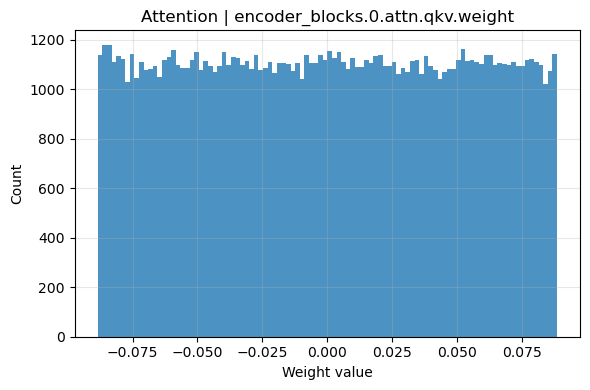

In [ ]:
# Per-module histograms
for qname, mod, kind in targets:
    params = summarize_module_params(mod)
    if not params:
        continue
    for pname, tensor in params.items():
        arr = tensor.detach().cpu().numpy().reshape(-1)
        plot_hist(arr, title=f"{kind} | {qname}.{pname}", bins=BINS)


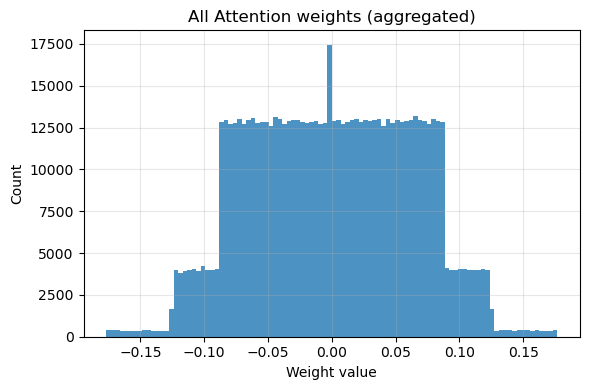

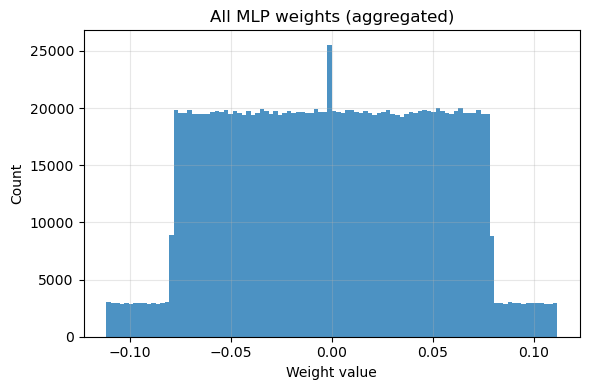

In [ ]:
# Aggregated histograms
attn_tensors: List[torch.Tensor] = []
mlp_tensors: List[torch.Tensor] = []

for _, mod, kind in targets:
    params = summarize_module_params(mod)
    if kind == "Attention":
        for _, tensor in params.items():
            attn_tensors.append(tensor.reshape(-1))
    elif kind == "MLP":
        for _, tensor in params.items():
            mlp_tensors.append(tensor.reshape(-1))

attn_all = flatten_tensors(attn_tensors)
mlp_all = flatten_tensors(mlp_tensors)

if attn_all.size > 0:
    plot_hist(attn_all, title="All Attention weights (aggregated)", bins=BINS)
else:
    print("No Attention weights found.")

if mlp_all.size > 0:
    plot_hist(mlp_all, title="All MLP weights (aggregated)", bins=BINS)
else:
    print("No MLP weights found.")
